## Outline of this notebook
- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks


## `sum`: An easy enough function to understand
Consider the **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.09914672525969803
 0.04582085901402233
 0.6535187000637086
 0.49087573379516836
 0.360190878385688
 0.086666997555504
 0.2724317927632576
 0.9436121793155015
 0.04189330198893437
 0.6598472669938217
 0.21373555942649758
 0.8597126670681936
 0.6402646086316456
 ⋮
 0.7957423852016681
 0.5931655069047674
 0.8136967572786934
 0.3296060025557448
 0.9024041981916724
 0.8719407531856725
 0.8280314966069449
 0.15879675182939734
 0.4599575097125794
 0.6710837254331055
 0.9667465310307126
 0.6391153598854827

In [2]:
sum(a)

5.000552785530698e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

## Benchmarking a fews in a few languages
Julia has a `BencmarkTools.jl package for easy and accurate benchmarking:

In [3]:
#Pkg.add("BenchmarkTools)
using BenchmarkTools

## 1. The C Language
C is often considered the gold standard: difficult on the human, nice for machine.
Getting withina factor of 2 of C is often satisfying. Nonetheless, even within C,
there are many kinds of optimizations possible that a naive  C writer maor may not get the advantage of.

The current author doesn't speak C, so he does not read the cell below, but is happy to know that
you can put C code in a Julia season, compile it, and run it. Note that the `"""` wrap a multi string.

In [4]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [5]:
c_sum(a)

5.000552785530852e6

In [6]:
c_sum(a) ≈ sum(a) # type \approx to get symbol ≈

true

In [7]:
c_sum(a) - sum(a)

1.5459954738616943e-7

In [8]:
≈ # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [9]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [10]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 192 samples with 1 evaluation.
 Range (min … max):  15.941 ms … 91.443 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     23.196 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   26.066 ms ± 10.637 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▁▇█▆▁▃                                                   
  ▆▇█▇██████▇▆▆▆▄▁▄▁▃▃▃▃▁▃▃▁▁▃▁▃▃▃▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▁▁▃▁▁▁▃ ▃
  15.9 ms         Histogram: frequency by time        73.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [11]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 15.9413 msec


In [12]:
d = Dict() # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6 # in millicseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 15.9413

In [13]:
using Plots
gr()

Plots.GRBackend()

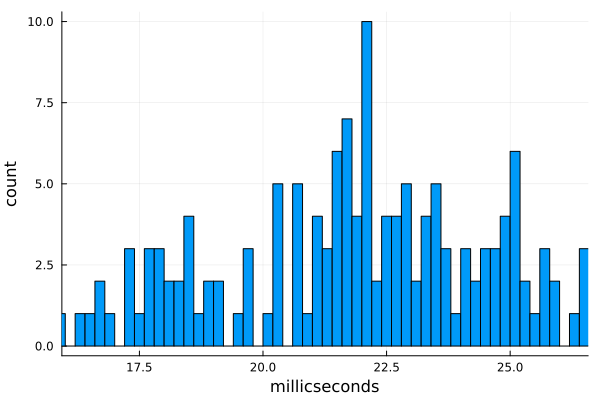

In [14]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim = (m-0.01, m+σ),
    xlabel = "millicseconds", ylabel = "count", label = "")

## 2. C with -ffast-math
if we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [15]:
const Clib_fastmath = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [16]:
c_sum_fastmath_bench = @benchmark c_sum_fastmath($a)

BenchmarkTools.Trial: 550 samples with 1 evaluation.
 Range (min … max):  7.378 ms … 32.848 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.707 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.067 ms ±  1.764 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                           
  █▆▇▄▃▄▃▅▅▅▆▅▅▄▄▄▅▅▄▃▅▃▃▅▃▅▃▅▃▃▂▄▄▃▄▃▂▃▃▃▂▃▂▂▁▁▂▂▁▃▁▂▂▁▂▁▁▂ ▃
  7.38 ms        Histogram: frequency by time        13.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [17]:
d["C -ffast-math"] = minimum(c_sum_fastmath_bench.times) / 1e6 # in milliseconds

7.3781

## 3. Python's built-in `sum`
the `PyCall` package provides a Julia interface to Python:

In [18]:
# using Pkg; Pkg.add("PyCall")
using PyCall

In [19]:
# get the Python built-in "sum" function
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [20]:
pysum(a)

5.000552785530852e6

In [21]:
pysum(a) ≈ sum(a)

true

In [22]:
py_list_bench = @benchmark pysum(a)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.177 s …    1.505 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.199 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.270 s ± 156.746 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ █  █                                                   █  
  █▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.18 s         Histogram: frequency by time          1.5 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [24]:
d["Python built-in"] = minimum(py_list_bench.times)/1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 15.9413
  "Python built-in" => 1177.49
  "C -ffast-math"   => 7.3781

## 4. Python: `numpy`
### Takes advantage of hardware "SIMD", but only works when it works.
`numpy` is an optimized C library, calable from Python. It may be installed within Julia as follows:

In [25]:
using Pkg
Pkg.add("Conda")

    Updating registry at `C:\Users\lenovo\.julia\registries\General.toml`
   Resolving package versions...
    Updating `D:\Data Science Lesson\Learn_Julia\Exploring-Julia\Project.toml`
  [8f4d0f93] + Conda v1.7.0
  No Changes to `D:\Data Science Lesson\Learn_Julia\Exploring-Julia\Manifest.toml`


In [26]:
using Conda
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda C:\Users\lenovo\.julia\packages\Conda\x2UxR\src\Conda.jl:127


Retrieving notices: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\lenovo\.julia\conda\3

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numpy-1.24.1               |  py310hd02465a_0         5.6 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.6 MB

The following packages will be DOWNGRADED:

  numpy                              1.24.1-py310h4a8f9c9_0 --> 1.24.1-py310hd02465a_0 



                                                     
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [27]:
numpy_sum = pyimport("numpy")["sum"]
py_numpy_bench = @benchmark numpy_sum(a)

BenchmarkTools.Trial: 320 samples with 1 evaluation.
 Range (min … max):  12.122 ms … 30.254 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.606 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.622 ms ±  2.101 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▂▂▃ ▂▁  ▁ █▅▁                                         
  ▃▆▄▃▃▁▅███▆██▅███████▆▆▅▄▄▃▃▂▃▂▁▁▁▁▁▂▁▁▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂ ▃
  12.1 ms         Histogram: frequency by time        25.2 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [28]:
numpy_sum(a)

5.000552785530696e6

In [29]:
numpy_sum(a) ≈ sum(a)

true

In [30]:
d["Python numpy"] = minimum(py_numpy_bench.times)/1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 15.9413
  "Python numpy"    => 12.1221
  "Python built-in" => 1177.49
  "C -ffast-math"   => 7.3781

## 5. Python, hand-written

In [32]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x000001EF5AED5AB0>

In [50]:
py_hand = @benchmark sum_py(a)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.711 s …    2.253 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.909 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.958 s ± 274.498 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                    █                                   █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.71 s         Histogram: frequency by time         2.25 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [51]:
sum_py(a)

5.000552785530852e6

In [52]:
sum_py(a) ≈ sum(a)

true

In [53]:
d["Python hand-written"] = minimum(py_hand.times)/1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 5.2486
  "C"                       => 15.9413
  "Python numpy"            => 12.1221
  "Julia hand-written"      => 14.1733
  "Python hand-written"     => 1711.02
  "Python built-in"         => 1177.49
  "Julia built-in"          => 5.3211
  "C -ffast-math"           => 7.3781

## 6. Julia (built-in)
Written directly in Julia, not in C!

In [54]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:994

In [55]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 693 samples with 1 evaluation.
 Range (min … max):  5.271 ms … 19.447 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.716 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.185 ms ±  1.950 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▄█                                                        
  █▃██▇▄▄▅▆▃▇█▇▆▄▄▄▃▃▃▃▃▃▂▂▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▂▂▁▂ ▃
  5.27 ms        Histogram: frequency by time          15 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [56]:
d["Julia built-in"] = minimum(j_bench.times)/1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 5.2486
  "C"                       => 15.9413
  "Python numpy"            => 12.1221
  "Julia hand-written"      => 14.1733
  "Python hand-written"     => 1711.02
  "Python built-in"         => 1177.49
  "Julia built-in"          => 5.2708
  "C -ffast-math"           => 7.3781

## 7. Julia (hand-written)

In [57]:
function mysum(A)
    s = 0.0     # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [58]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 237 samples with 1 evaluation.
 Range (min … max):  14.259 ms … 83.806 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     19.673 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.074 ms ±  6.386 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▂█▁▃▂ ▁                                               
  ▃▄▃▅▅▇██████▇█▆▆▃▄▃▅▄▃▃▃▃▃▃▁▃▃▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂ ▃
  14.3 ms         Histogram: frequency by time        45.1 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [59]:
d["Julia hand-written"] = minimum(j_bench_hand.times)/1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 5.2486
  "C"                       => 15.9413
  "Python numpy"            => 12.1221
  "Julia hand-written"      => 14.2587
  "Python hand-written"     => 1711.02
  "Python built-in"         => 1177.49
  "Julia built-in"          => 5.2708
  "C -ffast-math"           => 7.3781

## 8. Julia (hand-written w. simd)

In [60]:
function mysum_simd(A)
    s = 0.0     # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [61]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 668 samples with 1 evaluation.
 Range (min … max):  5.250 ms … 40.671 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.824 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.454 ms ±  2.793 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █  ▄                                                        
  █▇▇█▇▆▄▅▆▆▄▄▅▄▄▄▆▅▄▅▃▄▃▃▃▄▃▃▃▂▃▂▂▁▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂ ▃
  5.25 ms        Histogram: frequency by time        16.6 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [62]:
mysum_simd(a)

5.0005527855307255e6

In [63]:
mysum_simd(a) ≈ sum(a)

true

In [64]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times)/1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 5.2496
  "C"                       => 15.9413
  "Python numpy"            => 12.1221
  "Julia hand-written"      => 14.2587
  "Python hand-written"     => 1711.02
  "Python built-in"         => 1177.49
  "Julia built-in"          => 5.2708
  "C -ffast-math"           => 7.3781

In [65]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....5.2
Julia built-in..............5.3
C -ffast-math...............7.4
Python numpy...............12.1
Julia hand-written.........14.3
C..........................15.9
Python built-in..........1177.5
Python hand-written......1711.0
